In [1]:
#importing libraries
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading data
df=pd.read_csv("../datasets/df.csv")
df.tail()

,text,subreddit,score,num_comments
39995,Trump begins his witchhunt against Green Energ...,RenewableEnergy,261,90.0
39996,New Report: Switch to a Clean Energy Economy “...,RenewableEnergy,1,0.0
39997,Buy vs. Lease Solar Panels: Which Option Is Be...,RenewableEnergy,1,0.0
39998,Residential Solar Water Heater Idea,RenewableEnergy,11,7.0
39999,Port Of Long Beach Goes Greener With Solar Car...,RenewableEnergy,15,0.0


In [3]:

df['subreddit'] = [1 if i == 'RenewableEnergy' else 0 for i in df['subreddit']]

In [4]:
df

,text,subreddit,score,num_comments
0,"&gt;the article is about ""new"" cars, not ""all""...",0,1,0.0
1,What a non-sense article. Good luck trying to ...,0,2,0.0
2,Tesla semi will be a game changer for this,0,1,0.0
3,"Well, you know, I oversimplified. They are tr...",0,1,0.0
4,90 miles is 144.84 km,0,1,0.0
...,...,...,...,...
39995,Trump begins his witchhunt against Green Energ...,1,261,90.0
39996,New Report: Switch to a Clean Energy Economy “...,1,1,0.0
39997,Buy vs. Lease Solar Panels: Which Option Is Be...,1,1,0.0
39998,Residential Solar Water Heater Idea,1,11,7.0


In [5]:
df.isnull().sum().sum()

0

## sentiment analyzer

In [6]:
# instantiate the sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [7]:
# Write a function to get the compound sentiment scores for a post
def get_compound_sentiment(post):
    return sia.polarity_scores(post)['compound']

In [8]:
df['sentiment'] = df['text'].apply(get_compound_sentiment)

In [9]:
df['subreddit'].corr(df['sentiment'])

0.0873387319851582

## EDA

## Data cleaning function for text data

In [10]:
def text_to_words(raw_review):
    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_review).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))#,'energy','renewable'))
    
    # 5. Remove stopwords.
    meaningful_words = [w for w in words if not w in stops]
    
    #6.lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemmmatized_words=[lemmatizer.lemmatize(i) for i in meaningful_words]
    
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(lemmmatized_words))

## Apply cleaning function

In [11]:
# Initialize an empty list to hold the clean text.
clean_text = []
total_reviews = df.shape[0]
for train_review in df['text']:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_text.append(text_to_words(train_review))

In [12]:
df["cleaned_text"]=clean_text

In [13]:
df['cleaned_text'] = df['cleaned_text'].map(lambda x: re.sub('renewable', '', x))

In [14]:
df['cleaned_text'] = df['cleaned_text'].map(lambda x: re.sub('energy', '', x))

In [15]:
df['cleaned_text'] = df['cleaned_text'].map(lambda x: re.sub('renew', '', x))

In [16]:
df

,text,subreddit,score,num_comments,sentiment,cleaned_text
0,"&gt;the article is about ""new"" cars, not ""all""...",0,1,0.0,0.9248,article new car car yes entire article basical...
1,What a non-sense article. Good luck trying to ...,0,2,0.0,0.7357,non sense article good luck trying move ton tr...
2,Tesla semi will be a game changer for this,0,1,0.0,0.0000,tesla semi game changer
3,"Well, you know, I oversimplified. They are tr...",0,1,0.0,0.8689,well know oversimplified trying regain market ...
4,90 miles is 144.84 km,0,1,0.0,0.0000,mile km
...,...,...,...,...,...,...
39995,Trump begins his witchhunt against Green Energ...,1,261,90.0,0.2732,trump begin witchhunt green seek name departm...
39996,New Report: Switch to a Clean Energy Economy “...,1,1,0.0,0.5859,new report switch clean economy irrevocably u...
39997,Buy vs. Lease Solar Panels: Which Option Is Be...,1,1,0.0,0.4404,buy v lease solar panel option better homeowner
39998,Residential Solar Water Heater Idea,1,11,7.0,0.0000,residential solar water heater idea


## Feature engineering

### Features for number of word and char

In [17]:
df['char_count'] = df.text.map(len)

In [18]:
df['word_count'] = df.text.map(lambda x: len(x.split()))

In [19]:
df

,text,subreddit,score,num_comments,sentiment,cleaned_text,char_count,word_count
0,"&gt;the article is about ""new"" cars, not ""all""...",0,1,0.0,0.9248,article new car car yes entire article basical...,1142,186
1,What a non-sense article. Good luck trying to ...,0,2,0.0,0.7357,non sense article good luck trying move ton tr...,1627,256
2,Tesla semi will be a game changer for this,0,1,0.0,0.0000,tesla semi game changer,42,9
3,"Well, you know, I oversimplified. They are tr...",0,1,0.0,0.8689,well know oversimplified trying regain market ...,353,60
4,90 miles is 144.84 km,0,1,0.0,0.0000,mile km,21,5
...,...,...,...,...,...,...,...,...
39995,Trump begins his witchhunt against Green Energ...,1,261,90.0,0.2732,trump begin witchhunt green seek name departm...,123,18
39996,New Report: Switch to a Clean Energy Economy “...,1,1,0.0,0.5859,new report switch clean economy irrevocably u...,67,10
39997,Buy vs. Lease Solar Panels: Which Option Is Be...,1,1,0.0,0.4404,buy v lease solar panel option better homeowner,65,11
39998,Residential Solar Water Heater Idea,1,11,7.0,0.0000,residential solar water heater idea,35,5


## Data visuallization for numeric features

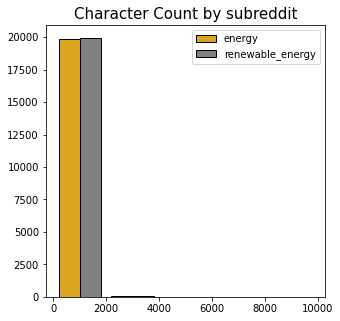

In [20]:
plt.figure(figsize=(5,5))
plt.hist([df[df['subreddit']==0]['char_count'], 
          df[df['subreddit']==1]['char_count']],
         bins=5,color=['goldenrod', 'grey'], ec='k')
plt.title('Character Count by subreddit', fontsize=15)
plt.legend(['energy', 'renewable_energy']);
plt.savefig('../plots/character_count.png', dpi=235)

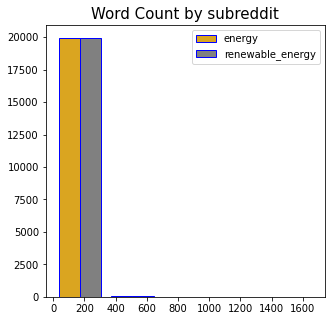

In [21]:
plt.figure(figsize=(5,5))
plt.hist([df[df['subreddit']==0]['word_count'], df[df['subreddit']==1]['word_count']],
         bins=5, color=['goldenrod', 'grey'], ec='b')
plt.title('Word Count by subreddit', fontsize=15)
plt.legend(['energy', 'renewable_energy']);
plt.savefig('../plots/word_count.png', dpi=235)

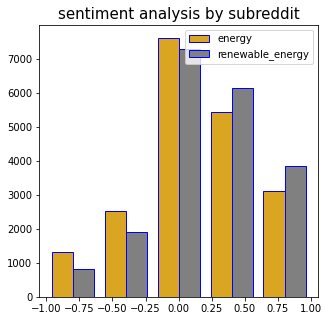

In [22]:
plt.figure(figsize=(5,5))
plt.hist([df[df['subreddit']==0]["sentiment"], df[df['subreddit']==1]["sentiment"]],
         bins=5, color=['goldenrod', 'grey'], ec='b')
plt.title('sentiment analysis by subreddit', fontsize=15)
plt.legend(['energy', 'renewable_energy']);
plt.savefig('../plots/sentiment_analyzer.png', dpi=235)

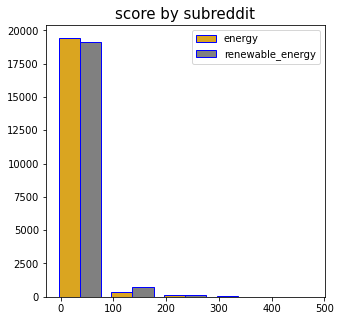

In [23]:
plt.figure(figsize=(5,5))
plt.hist([df[df['subreddit']==0]["score"], df[df['subreddit']==1]["score"]],
         bins=5, color=['goldenrod', 'grey'], ec='b')
plt.title('score by subreddit', fontsize=15)
plt.legend(['energy', 'renewable_energy']);
plt.savefig('../plots/score.png', dpi=235)

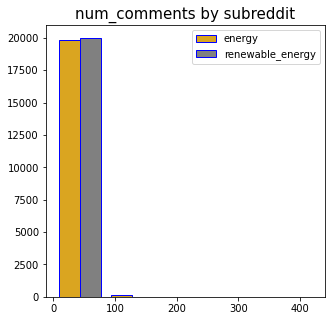

In [24]:
plt.figure(figsize=(5,5))
plt.hist([df[df['subreddit']==0]["num_comments"], df[df['subreddit']==1]["num_comments"]],
         bins=5, color=['goldenrod', 'grey'], ec='b')
plt.title('num_comments by subreddit', fontsize=15)
plt.legend(['energy', 'renewable_energy']);
plt.savefig('../plots/num_col.png', dpi=235)

### The distribution of top unigrams after removing stop words

solar 9294
power 6419
wind 4814
year 3874
battery 3563
gas 3498
oil 3469
hydrogen 3386
cost 3378
fuel 3336
new 3306
storage 3114
coal 3093
http 3084
nuclear 3060
like 3034
plant 2882
need 2781
make 2587
electricity 2577


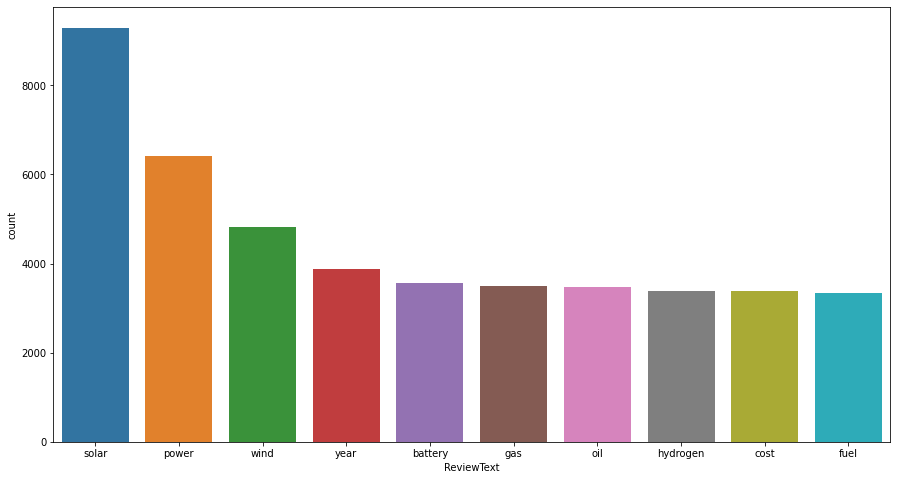

In [25]:

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['cleaned_text'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count']).sort_values(by=['count'],ascending=False).head(10)
#df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(x=df2['ReviewText'],y=df2['count'])
plt.savefig('../plots/top_unigrams_1.png', dpi=235)

### The distribution of top bigrams after removing stop words


http www 1531
fossil fuel 1378
natural gas 1104
solar panel 950
solar power 843
wind solar 795
power plant 788
climate change 717
fuel cell 709
solar wind 652
wind turbine 631
nuclear power 619
offshore wind 462
wind farm 455
wind power 415
reddit com 415
electric car 399
oil gas 392
coal plant 360
make sense 320


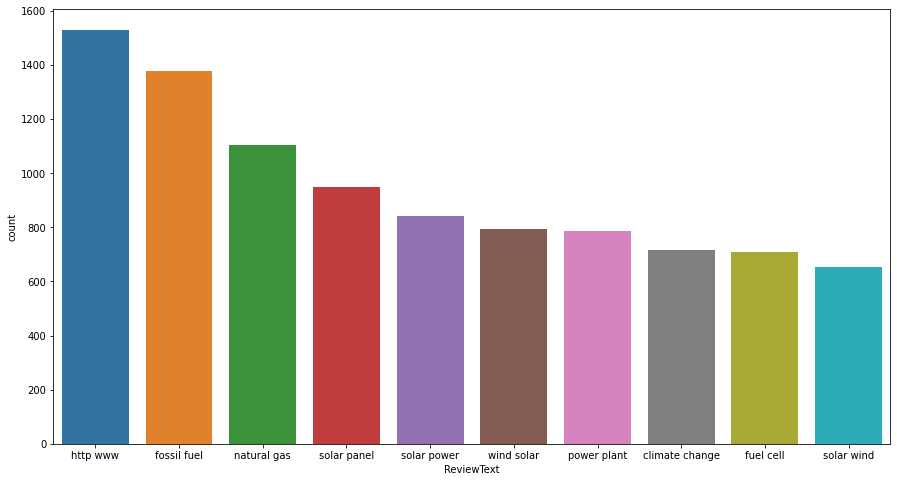

In [26]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['cleaned_text'], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count']).sort_values(by=['count'],ascending=False).head(10)
#df4.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(x=df4['ReviewText'],y=df4['count'])
plt.savefig('../plots/top_bigrams_1.png', dpi=235)

### The distribution of Top trigrams after removing stop words

http en wikipedia 250
en wikipedia org 250
wikipedia org wiki 249
http np reddit 241
np reddit com 241
nuclear power plant 205
hydrogen fuel cell 170
reddit com message 163
com message compose 163
lithium ion battery 128
http www youtube 113
www youtube com 113
youtube com watch 105
http www reddit 100
www reddit com 100
fossil fuel industry 99
green new deal 98
offshore wind farm 95
coal fired power 84
solar plus storage 80


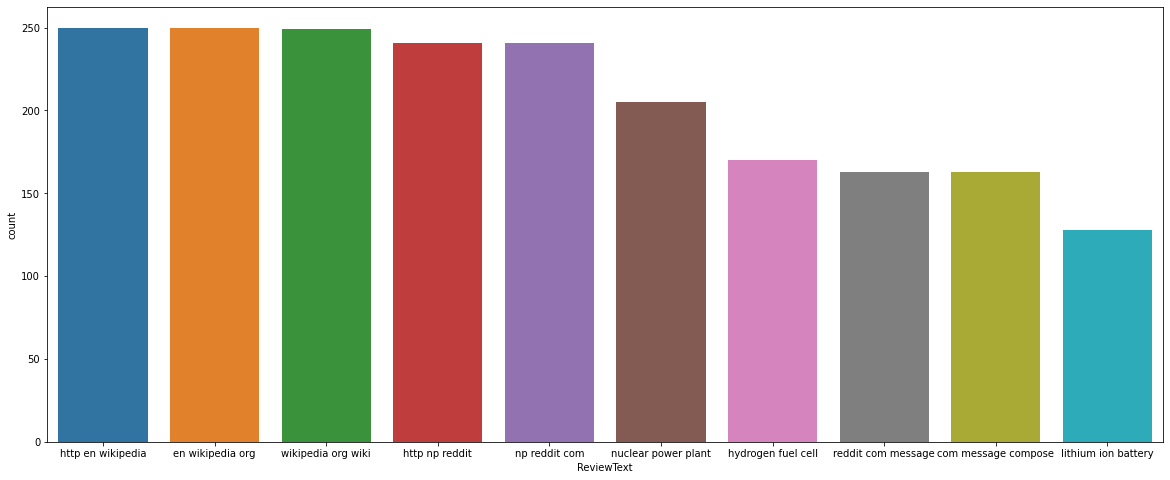

In [27]:

def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['cleaned_text'], 20)
for word, freq in common_words:
    print(word, freq)
df6 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count']).sort_values(by=['count'],ascending=False).head(10)
#df6.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
plt.figure(figsize=(20,8))
sns.barplot(x=df6['ReviewText'],y=df6['count'])
plt.savefig('../plots/top_trigrams_1.png', dpi=235)

## Remove words that are none-sense

In [28]:
dirty_word=['http', 'np' ,'reddit','en','wikipedia','com','org','wiki','www','youtube','watch','message']

In [29]:
re_banned_words = re.compile(r"\b(" + "|".join(dirty_word) + ")\\W", re.I)

In [30]:
def RemoveBannedWords(x):
    global re_banned_words
    return re_banned_words.sub("", x)



In [31]:
df['cleaned_text'] = df['cleaned_text'].apply(RemoveBannedWords)

## Now again top words

### Top words in renewable

nuclear power plant 69
lithium ion battery 64
offshore wind farm 59
pv magazine usa 47
virtual power plant 46
wind solar power 45
solar plus storage 45
america actually uninhabited 43
utility scale solar 41
solar power plant 41
actually uninhabited america 41
uninhabited america actually 41
li ion battery 37
best tl dr 36
tl dr make 36
dr make original 36
extended summary autotldr 36
summary autotldr comment 36
faq autotldr comment 36
autotldr comment fm 36


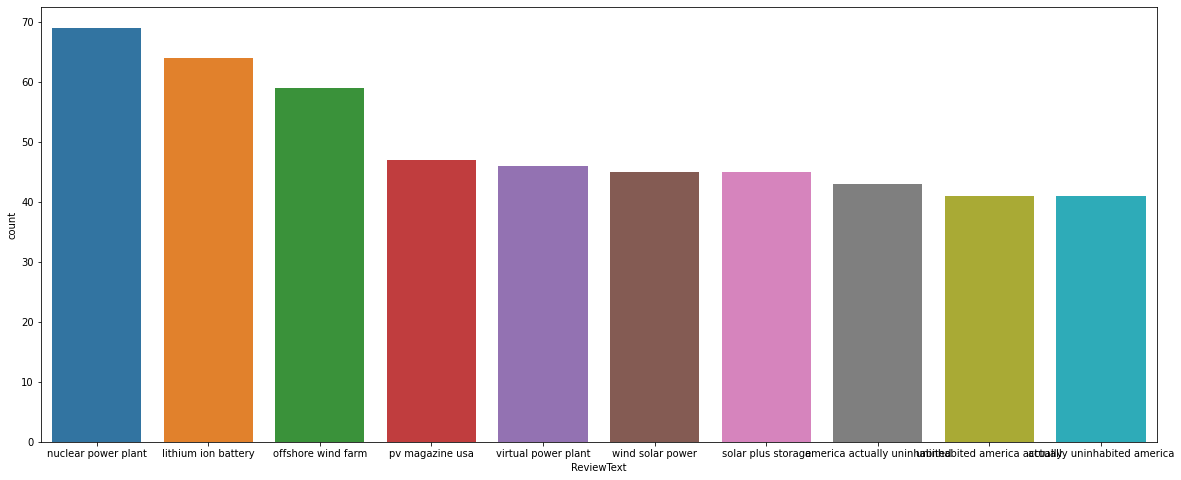

In [32]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['cleaned_text'][df["subreddit"]==1], 20)
for word, freq in common_words:
    print(word, freq)
df6 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count']).sort_values(by=['count'],ascending=False).head(10)
#df6.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
plt.figure(figsize=(20,8))
sns.barplot(x=df6['ReviewText'],y=df6['count'])
plt.savefig('../plots/top_trigrams_best.png', dpi=235)

hydrogen fuel cell 137
nuclear power plant 136
fossil fuel industry 67
lithium ion battery 64
fuel cell vehicle 63
green new deal 62
coal fired power 53
fired power plant 46
fossil fuel subsidy 43
coal power plant 40
offshore wind farm 36
oil natural gas 35
oil gas industry 35
fossil fuel company 35
solar storage home 35
solar plus storage 35
wind solar power 34
fuel cell bus 33
coal natural gas 31
utility scale solar 30


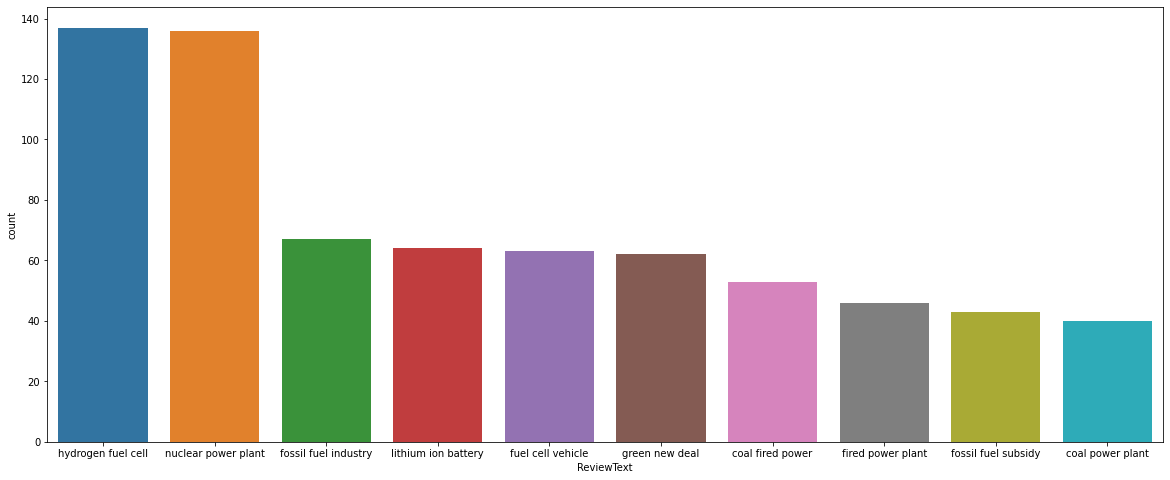

In [33]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['cleaned_text'][df["subreddit"]==0], 20)
for word, freq in common_words:
    print(word, freq)
df6 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count']).sort_values(by=['count'],ascending=False).head(10)
#df6.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
plt.figure(figsize=(20,8))
sns.barplot(x=df6['ReviewText'],y=df6['count'])
plt.savefig('../plots/top_trigrams_best.png', dpi=235)

fossil fuel 653
solar panel 638
solar power 561
wind turbine 475
wind solar 429
solar wind 379
climate change 373
power plant 360
natural gas 355
wind farm 325
offshore wind 283
nuclear power 271
wind power 268
solar farm 204
battery storage 176
solar cell 165
electric car 159
make sense 150
coal plant 141
solar project 133


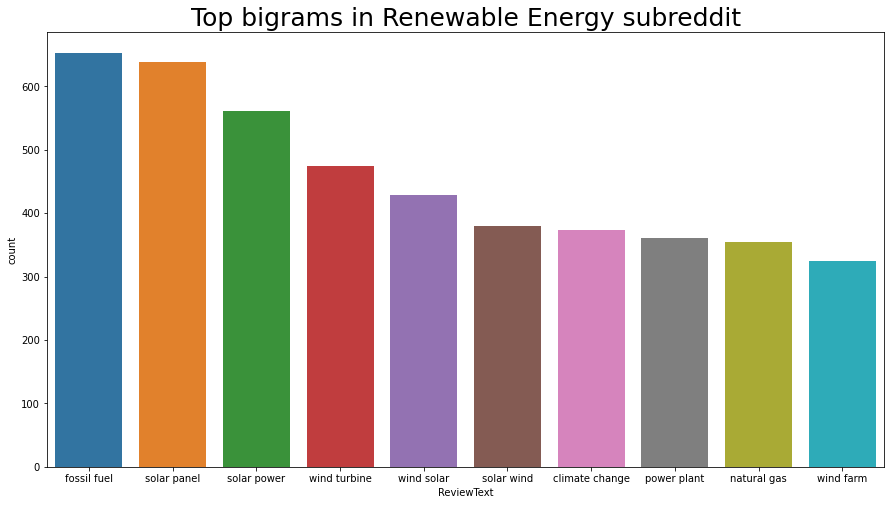

In [34]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['cleaned_text'][df["subreddit"]==1], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count']).sort_values(by=['count'],ascending=False).head(10)
#df4.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(x=df4['ReviewText'],y=df4['count'])
plt.title("Top bigrams in Renewable Energy subreddit",fontsize=25)
plt.savefig('../plots/top_bigrams_renew.png', dpi=235)

natural gas 749
fossil fuel 725
fuel cell 602
power plant 428
wind solar 366
nuclear power 348
climate change 344
solar panel 312
oil gas 301
solar power 282
solar wind 273
oil price 250
electric car 240
green hydrogen 225
coal plant 219
electric vehicle 198
hydrogen fuel 198
saudi arabia 182
offshore wind 179
make sense 170


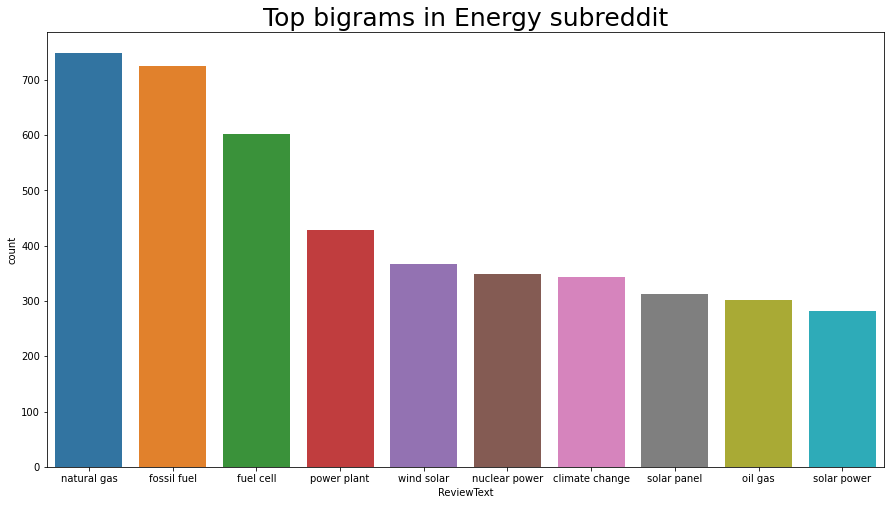

In [35]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['cleaned_text'][df["subreddit"]==0], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count']).sort_values(by=['count'],ascending=False).head(10)
#df4.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(x=df4['ReviewText'],y=df4['count'])
plt.title("Top bigrams in Energy subreddit",fontsize=25)
plt.savefig('../plots/top_bigrams_energy.png', dpi=235)

## Top words in Renewable subreddit

solar 6004
power 3553
wind 3145
year 1871
battery 1747
new 1661
storage 1637
cost 1616
like 1492
need 1335
nuclear 1326
plant 1301
fuel 1295
make 1287
electricity 1261
coal 1202
gas 1169
grid 1108
company 1083
project 1078


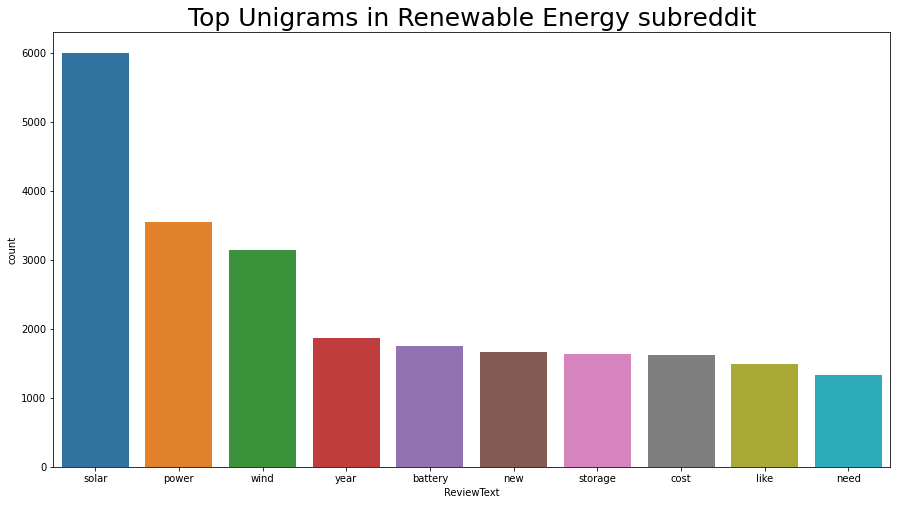

In [36]:

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words_renew = get_top_n_words(df['cleaned_text'][df["subreddit"]==1], 20)
for word, freq in common_words_renew :
    print(word, freq)
df2 = pd.DataFrame(common_words_renew , columns = ['ReviewText' , 'count']).sort_values(by=['count'],ascending=False).head(10)
#df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(x=df2['ReviewText'],y=df2['count'])
plt.title("Top Unigrams in Renewable Energy subreddit",fontsize=25)
plt.savefig('../plots/top_unigrams_renewable.png', dpi=235)

## Top words in energy subreddit

solar 3290
oil 2896
power 2866
hydrogen 2777
gas 2329
fuel 2041
year 2003
coal 1891
battery 1816
cost 1762
nuclear 1734
wind 1669
new 1645
price 1583
plant 1581
like 1542
storage 1477
need 1446
market 1338
electricity 1316


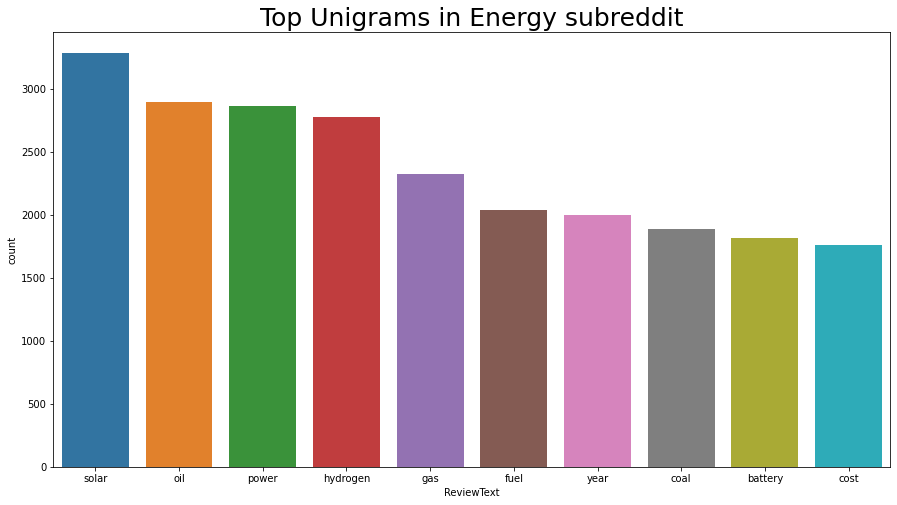

In [37]:

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words_energy = get_top_n_words(df['cleaned_text'][df["subreddit"]==0], 20)
for word, freq in common_words_energy:
    print(word, freq)
df2 = pd.DataFrame(common_words_energy, columns = ['ReviewText' , 'count']).sort_values(by=['count'],ascending=False).head(10)
#df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(x=df2['ReviewText'],y=df2['count'])
plt.title("Top Unigrams in Energy subreddit",fontsize=25)
plt.savefig('../plots/top_unigrams_energy.png', dpi=235)

## simple class feature

In [38]:
# Let's come up with a list of positive and negative words we might observe.

energy_words = ["oil","gas","hydrogen","plant","fuel","nuclear"]
renewable_energy_words = ["green","wind","geothermal","tidal","grid","storage","solar","biomass"]

In [39]:
def simple_class(text):
     # Instantiate tokenizer.
    tokenizer = RegexpTokenizer(r'\w+')
    
    # Tokenize text.
    tokens = tokenizer.tokenize(text.lower())
    # Count "energy" words.
    energy_count = sum([1 for i in tokens if i in energy_words])
    # Count "renewable energy" words
    renewable_energy_count = sum([1 for i in tokens if i in renewable_energy_words])
    if renewable_energy_count>energy_count:
        return "1"
    else:
        return "0"

In [40]:
df['simpe_class']=df["cleaned_text"].apply(simple_class)

In [41]:
df['simpe_class'].value_counts()

0    29803
1    10197
Name: simpe_class, dtype: int64

In [42]:
df["simpe_class"] = pd.to_numeric(df["simpe_class"])

In [43]:
df['subreddit'].corr(df['simpe_class'])

0.17352385122589312

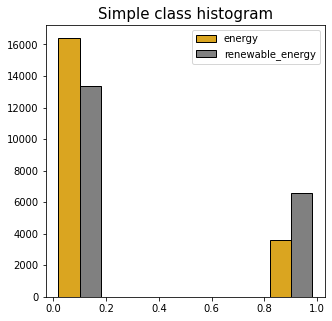

In [44]:
plt.figure(figsize=(5,5))
plt.hist([df[df['subreddit']==0]['simpe_class'], 
          df[df['subreddit']==1]['simpe_class']],
         bins=5, color=['goldenrod', 'grey'], ec='k')
plt.title('Simple class histogram', fontsize=15)
plt.legend(['energy', 'renewable_energy']);
plt.savefig('../plots/simple_class.png', dpi=235)

## Select the best features

In [45]:
df.drop(columns=['score','text','num_comments','char_count','word_count'],inplace=True)

In [46]:
df.isnull().sum().sum()

0

## Save the final cleaned dataset 

In [47]:
df[df["cleaned_text"]==""]

,subreddit,sentiment,cleaned_text,simpe_class
69,0,0.0,,0
377,0,0.0,,0
389,0,0.0,,0
636,0,0.0,,0
870,0,0.0,,0
...,...,...,...,...
33240,1,0.0,,0
35094,1,0.0,,0
38974,1,0.0,,0
38984,1,0.0,,0


In [48]:
df=df[df["cleaned_text"]!=""]

In [49]:
## SAve the data with best features
#code
df.to_csv('../datasets/df_final.csv', index=False)